# 1. fastText简介

fastText是一个快速文本分类算法，与基于神经网络的分类算法相比有两大优点：

- fastText在保持高精度的情况下加快了训练速度和测试速度

- fastText不需要预训练好的词向量，fastText会自己训练词向量

fastText两个重要的优化：Hierarchical Softmax、N-gram

# 2. 模型架构

fastText模型架构和word2vec中的CBOW很相似， 不同之处是fastText预测标签而CBOW预测的是中间词，即模型架构类似但是模型的任务不同。下面我们先看一下CBOW的架构：

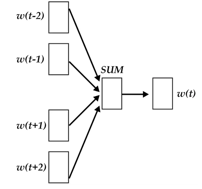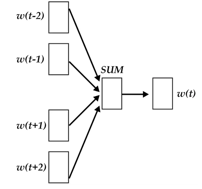

word2vec将上下文关系转化为多分类任务，进而训练逻辑回归模型，这里的类别数量|V|词库大小。通常的文本数据中，词库少则数万，多则百万，在训练中直接训练多分类逻辑回归并不现实。word2vec中提供了两种针对大规模多分类问题的优化手段， negative sampling 和hierarchical softmax。在优化中，negative sampling 只更新少量负面类，从而减轻了计算量。hierarchical softmax 将词库表示成前缀树，从树根到叶子的路径可以表示为一系列二分类器，一次多分类计算的复杂度从|V|降低到了树的高度

fastText模型架构:其中x1,x2,…,xN−1,xN表示一个文本中的n-gram向量，每个特征是词向量的平均值。这和前文中提到的cbow相似，cbow用上下文去预测中心词，而此处用全部的n-gram去预测指定类别

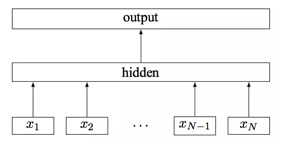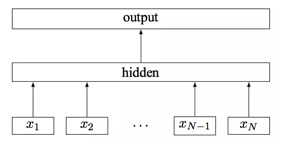

# 3. 层次softmax

在标准的softmax中，计算一个类别的softmax概率时，我们需要对所有类别概率做归一化，在这类别很大情况下非常耗时，因此提出了分层softmax(Hierarchical Softmax),思想是根据类别的频率构造霍夫曼树来代替标准softmax，通过分层softmax可以将复杂度从N降低到logN，下图给出分层softmax示例：

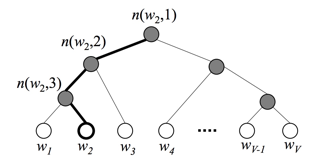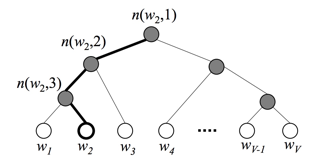

在层次softmax模型中，叶子结点的词没有直接输出的向量，而非叶子节点都有响应的输在在模型的训练过程中，通过Huffman编码，构造了一颗庞大的Huffman树，同时会给非叶子结点赋予向量。我们要计算的是目标词w的概率，这个概率的具体含义，是指从root结点开始随机走，走到目标词w的概率。因此在途中路过非叶子结点（包括root）时，需要分别知道往左走和往右走的概率。例如到达非叶子节点n的时候往左边走和往右边走的概率分别是：

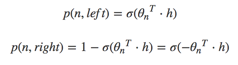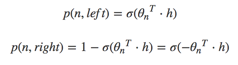

以上图中目标词为w2为例，

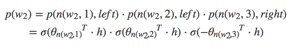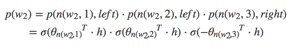

到这里可以看出目标词为w的概率可以表示为：

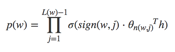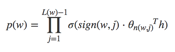

其中θn(w,j)是非叶子结点n(w,j)的向量表示（即输出向量）；h是隐藏层的输出值，从输入词的向量中计算得来；sign(x,j)是一个特殊函数定义

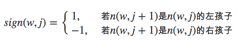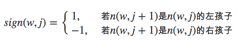

此外，所有词的概率和为1，即

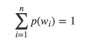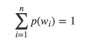

最终得到参数更新公式为：

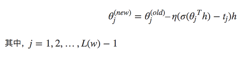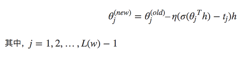


# 4. N-gram特征


使用n-gram有如下优点

- 为罕见的单词生成更好的单词向量：根据上面的字符级别的n-gram来说，即是这个单词出现的次数很少，但是组成单词的字符和其他单词有共享的部分，因此这一点可以优化生成的单词向量
- 在词汇单词中，即使单词没有出现在训练语料库中，仍然可以从字符级n-gram中构造单词的词向量
- n-gram可以让模型学习到局部单词顺序的部分信息, 如果不考虑n-gram则便是取每个单词，这样无法考虑到词序所包含的信息，即也可理解为上下文信息，因此通过n-gram的方式关联相邻的几个词，这样会让模型在训练的时候保持词序信息

但正如上面提到过，随着语料库的增加，内存需求也会不断增加，严重影响模型构建速度，针对这个有以下几种解决方案：
- 过滤掉出现次数少的单词
- 使用hash存储
- 由采用字粒度变化为采用词粒度

# 5. 代码实现

In [30]:
# 1 is positive, 0 is negative
f = open('train.txt', 'w')
f.write('__label__1 i love you\n')
f.write('__label__1 he loves me\n')
f.write('__label__1 she likes baseball\n')
f.write('__label__0 i hate you\n')
f.write('__label__0 sorry for that\n')
f.write('__label__0 this is awful')
f.close()

In [31]:
import fasttext

# 训练模型
model = fasttext.train_supervised(input="train.txt", epoch=25, lr=1.0, wordNgrams=2, verbose=2, minCount=1)

# 保存模型
model.save_model("model.bin")

Read 0M words
Number of words:  17
Number of labels: 2
Progress: 100.0% words/sec/thread:    1107 lr:  0.000000 avg.loss:       nan ETA:   0h 0m 0s


In [33]:
text = "i love you very"
label, confidence = model.predict(text)
print(f"Predicted label: {label[0]}, Confidence: {confidence[0]}")

Predicted label: __label__1, Confidence: 0.9670761227607727


In [35]:
text = "i hate you"
label, confidence = model.predict(text)
print(f"Predicted label: {label[0]}, Confidence: {confidence[0]}")

Predicted label: __label__0, Confidence: 0.9768641591072083


# 6. 练习

使用fasttext训练以下任务，评估模型效果

http://thuctc.thunlp.org/